#### Encontrar os equilíbrios: ELD (eq. livre de doença) EE (eq. endêmicos)
#### Por meio de metodo de linearização local, caracterizar as estabilidades dos equilíbrios

In [139]:
!pip install pandas

In [191]:
import pandas as pd
import math
import numpy as np
%display typeset

In [192]:
def ODE (t,y,params):
    S,E,I,A,R,D = y
    lambda_, alpha,p,theta,gamma, mu,mu1,mu2,t2 = params

    # transição de mu1 para mu2 
    mu = ( ( (np.tanh(-t + t2) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
    
    return [-lambda_*S*I,
            lambda_*S*I - alpha*E,
            (1-p)*alpha*E - gamma*I - mu*I,
            p*alpha*E - theta*A,
            gamma*I + theta*A,
            mu*I ]

In [193]:
lambda_ = 0.4
gamma = 0.03
theta = 0.09
alpha =  0.35
mu = 1
mu1 = 0.05
mu2 = 0.009
p = 0.3
t2 = 109

t = 90

mu = ( ( (np.tanh(-t + t2 ) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
print(mu)

0.05


In [194]:
T = ode_solver()
T.function = ODE
T.algorithm='rk8pd'
inits = [.95, 0,.05, 0, 0, 0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=200,
            params=[lambda_, alpha,p,theta,gamma, mu,mu1,mu2,t2])

In [195]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

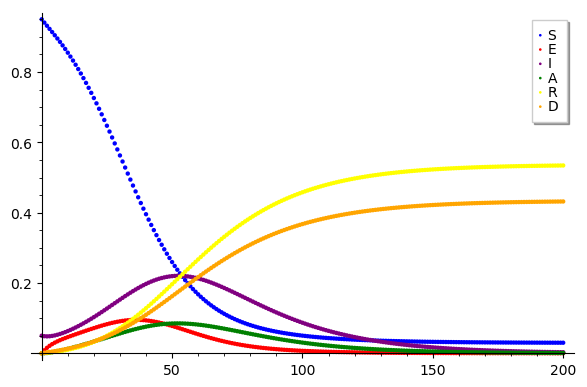

In [196]:
popFRA = 65e6
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='S')
    colors = ['blue','red','purple','green','yellow','orange']
    for i,var in enumerate(['E','I','A','R','D']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P)
plot_sol(T.solution)

In [226]:
var('t S E I A R D lambda_ gamma theta alpha mu p')

S = function('S')(t)
dsdt = diff(S,t) == -lambda_*S*I

E = function('E')(t)
dedt = diff(E,t) == lambda_*S*I - alpha*E

I = function('I')(t)
didt = diff(I,t) == (1-p)*alpha*E - gamma*I - mu*I

A = function('A')(t)
dadt = diff(A,t) == p*alpha*E - theta*A

R = function('R')(t)
drdt = diff(R,t) == gamma*I + theta*A

D = function('D')(t)
dddt = diff(D,t) == mu*I

dsdt , dedt , didt , dadt , drdt , dddt

(diff(S(t), t) == -I*lambda_*S(t),
 diff(E(t), t) == I*lambda_*S(t) - alpha*E(t),
 diff(I(t), t) == -alpha*(p - 1)*E(t) - gamma*I(t) - mu*I(t),
 diff(A(t), t) == alpha*p*E(t) - theta*A(t),
 diff(R(t), t) == theta*A(t) + gamma*I(t),
 diff(D(t), t) == mu*I(t))

#### Equilíbrio livre de doença

In [228]:
var('S E I A lambda_ gamma theta alpha mu p')
# R D são compartimentos desaclopados da dinâmica

dsdt = -lambda_*S*I

dedt = lambda_*S*I - alpha*E

didt = (1-p)*alpha*E - gamma*I - mu*I

dadt = p*alpha*E - theta*A

solve([dsdt,dedt,didt,dadt],[S,E,I,A])

[[S == r3, E == 0, I == 0, A == 0]]

#### R_0

In [229]:
# [E,I,A]
F_cal =  matrix([[lambda_*S*I],[0],[0]]) # taxa de surgimento de novos infectados
F_cal

[I*S*lambda_]
[          0]
[          0]

In [230]:
V_cal_neg = matrix([[alpha*E],[(gamma+mu)*I],[theta*A]]) # taxa de saída de infectados
V_cal_neg

[       E*alpha]
[I*(gamma + mu)]
[       A*theta]

In [231]:
V_cal_pos = matrix([[0],[(1-p)*alpha*E],[p*alpha*E]]) # taxa de entrada de infectados
V_cal_pos

[               0]
[-E*alpha*(p - 1)]
[       E*alpha*p]

In [232]:
V_cal = V_cal_neg - V_cal_pos
V_cal

[                         E*alpha]
[E*alpha*(p - 1) + I*(gamma + mu)]
[            -E*alpha*p + A*theta]

Definimos também $F=\left[\frac{\partial {\cal F}_i (x_0)}{\partial x_j}\right]$ e $V=\left[\frac{\partial {\cal V}_i (x_0) }{\partial x_j}\right]$, onde $x_0$ é um DFE (Equilíbrio livre de doença) e $1\leq i,j \leq m$. 

Isto equivale à jacobiana  destas duas matrizes, após substituir $x_0$ ou seja, $S=1$.

In [233]:
F = jacobian(F_cal(S=1),[E,I,A])
F

[      0 lambda_       0]
[      0       0       0]
[      0       0       0]

In [234]:
V = jacobian(V_cal(S=1),[E,I,A])
V

[        alpha             0             0]
[alpha*(p - 1)    gamma + mu             0]
[     -alpha*p             0         theta]

${\cal R}_0 = \rho (FV^{-1})$

In [235]:
M = F*V.inverse()

In [236]:
M=M.simplify_full()
M

[-(lambda_*p - lambda_)/(gamma + mu)                lambda_/(gamma + mu)                                   0]
[                                  0                                   0                                   0]
[                                  0                                   0                                   0]

In [237]:
M.eigenvalues()

[-(lambda_*p - lambda_)/(gamma + mu), 0, 0]

In [238]:
R0=M[0,0].simplify_full()
R0

-(lambda_*p - lambda_)/(gamma + mu)

In [239]:
R0.variables()

(gamma, lambda_, mu, p)

In [240]:
Ft = jacobian(F_cal,[E,I,A])
Vt = jacobian(V_cal,[E,I,A])
Mt = Ft*Vt.inverse()
show(pretty_print(html('$R_t=$')))
Rt = Mt[0,0]
Rt

<script type="math/tex">R_t=</script>

None

-S*lambda_*(p - 1)/(gamma + mu)

In [241]:
print(Rt)

-S*lambda_*(p - 1)/(gamma + mu)


In [243]:
R0( alpha = 0.6684073756819044,
    gamma = 0.3853253525597315,
    lambda_ =  0.7367833376680964,
    mu = 0.11275741330495165,
    p = 0.6627873853056002) # valores do sherpa sem os dados

0.498817973207738

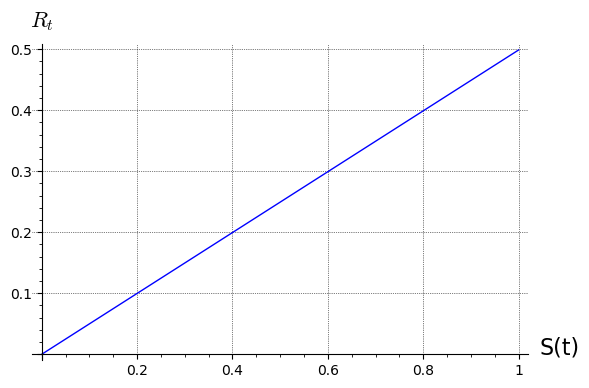

In [245]:
P = plot(Rt(alpha = 0.6684073756819044,
            gamma = 0.3853253525597315,
            lambda_ =  0.7367833376680964,
            mu = 0.11275741330495165,
            p = 0.6627873853056002),(S,0,1))
P.show(axes_labels=['S(t)','$R_t$'], gridlines=True)